In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple


In [2]:
import os, sys
root_path = os.path.realpath('../')
sys.path.append(root_path)
from utils.utils import fit_transform, front_frame, input_frame, input_label, make_datasets

c:\Users\Timo\anaconda3\envs\rnn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# set params
coordinate_type = "Cartesian"
input_type = "SC"
label_type = "WC"
title = f"Input type: {input_type}, Label type: {label_type}, {coordinate_type} coordinates"


### 1. understand utils.front_frame

In [111]:
def show_frame(frames: np.ndarray, coords: Tuple, idx: int):
    plt.imshow(frames[idx,:,:])
    plt.scatter(start_poke_coordinate[1,idx],coords[0][0,idx],s=400,marker='o',edgecolor='lightgreen',facecolor="none",alpha=1)
    plt.scatter(target_poke_coordinate[1,idx],coords[1][0,idx],s=400,marker='o',edgecolor='yellow',facecolor="none",alpha=1)
    

In [112]:
from utils import random_poke_generator
samples = random_poke_generator(5,3)
samples

array([[20, 43, 26, 29,  2],
       [20, 34, 38, 40, 11]])

In [115]:
# understand front_frame
frames, start_poke_coordinate, target_poke_coordinate = front_frame(
    random_seed=20, frame_amount=5000)

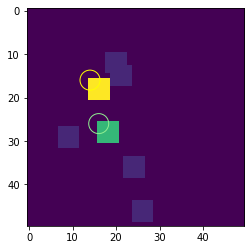

In [114]:
idx = 0
show_frame(frames,(start_poke_coordinate, target_poke_coordinate), idx)


In [109]:
np.unique(frames[idx,:,:])

array([0.1, 0.2, 0.7, 1. ])

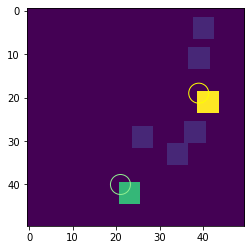

In [53]:
idx = 2
show_frame(frames, (start_poke_coordinate, target_poke_coordinate), idx)

### 2. understand utils.input_frame

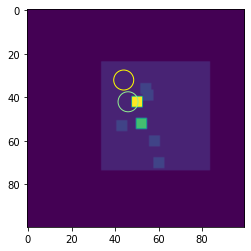

In [55]:
#understand input_frame
idx = 0
x_train = input_frame(frames, input_type, start_poke_coordinate)
plt.imshow(x_train[idx,:,:])
plt.scatter(start_poke_coordinate[1,idx]+30,start_poke_coordinate[0,idx]+16,s=400,marker='o',edgecolor='lightgreen',facecolor="none",alpha=1)
plt.scatter(target_poke_coordinate[1,idx]+30,target_poke_coordinate[0,idx]+16,s=400,marker='o',edgecolor='yellow',facecolor="none",alpha=1)

Text(0.5, 0.98, 'World-centered starting location')

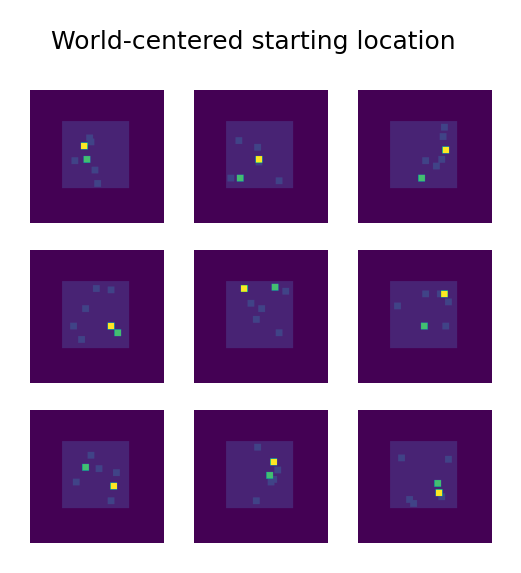

In [56]:
f, axs = plt.subplots(3,3,figsize=(2,2),dpi=300)
x_train = input_frame(frames, output_type="WC", start_poke=start_poke_coordinate)
axs = axs.ravel()
for ax,img in zip(axs,x_train):
    ax.imshow(img)
    ax.set_axis_off()
f.suptitle("World-centered starting location", fontsize=6)


Text(0.5, 0.98, 'Self-centered starting location')

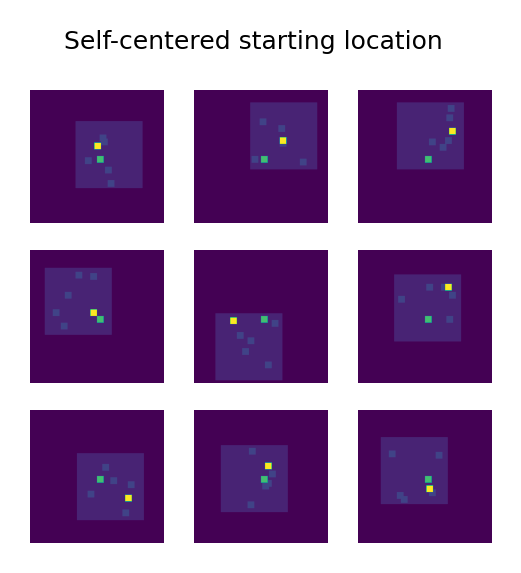

In [57]:
f, axs = plt.subplots(3,3,figsize=(2,2),dpi=300)
x_train = input_frame(frames, output_type="SC", start_poke=start_poke_coordinate)
axs = axs.ravel()
for ax,img in zip(axs,x_train):
    ax.imshow(img)
    ax.set_axis_off()
f.suptitle("Self-centered starting location", fontsize=6)

### 3. understand labels

In [60]:
unique_locs = {}
for xy in start_poke_coordinate.T:
    if not str(xy) in unique_locs:
        unique_locs[str(xy)] = 1
print(len(unique_locs.keys()))



1798


In [61]:
unique_locs = {}
for xy in target_poke_coordinate.T:
    if not str(xy) in unique_locs:
        unique_locs[str(xy)] = 1
print(len(unique_locs.keys()))


1794


## Sanity check

In [ ]:
data_train, data_test = make_datasets(size_ds=40)

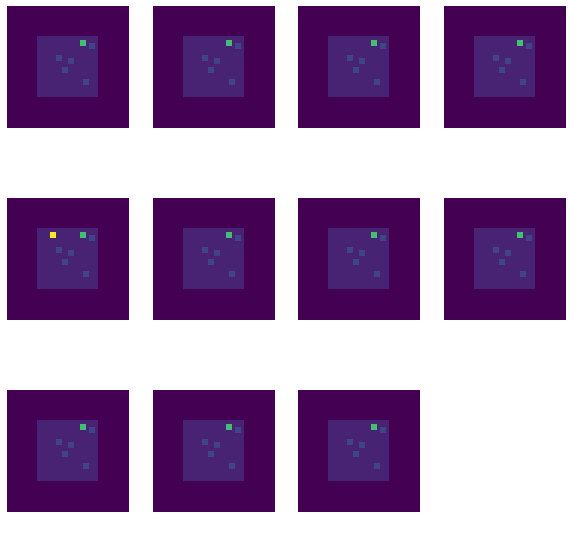

In [3]:
f,axs = plt.subplots(3,4,figsize=(10,10))
axs = axs.flatten()

for i,ax in enumerate(axs[:-1]):
    
    im = ax.imshow(data_train[0][4,i,:].reshape(40,40))
    im.set_clim(0,1)
    ax.set_axis_off()

axs[-1].set_axis_off()

In [42]:
import torch
from torch import nn

class RNN(nn.Module):
    def __init__(self, input_size: int = 10, hidden_size: int = 100, output_size: int = 2, nonlinearity: str = "tanh",device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
        super(RNN, self).__init__()
        self.n_inputs = input_size        
        self.n_hidden = hidden_size
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, nonlinearity=nonlinearity, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_size, out_features=output_size)
        self.ro = None
        self.device  = device

    def forward(self, x):
        h0 = self._init_hidden(batch_size=x.shape[0])
        self.ro, _ = self.rnn(x, h0)
        y = self.fc(self.ro[:, -1,:])
        return y

    def _init_hidden(self,batch_size=1):        
        return torch.zeros(1,batch_size, self.n_hidden).to(self.device)


    @property
    def hidden_states(self):
        return self.ro.cpu().detach().numpy()

tensor([[0.0626, 0.0027]], device='cuda:0', grad_fn=<AddmmBackward0>)

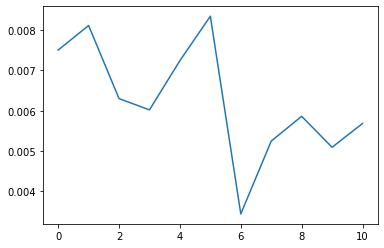

In [20]:
plt.plot(rnn.hidden_states.mean(2).flatten())

In [21]:
# try to overfit on training data:
x_train = torch.tensor(data_train[0][0:10,:],dtype=torch.float).to("cuda:0")
y_train = torch.tensor(data_train[1][0:10,:],dtype=torch.float).to("cuda:0")


In [37]:
rnn = RNN(input_size=1600,hidden_size=5,batch_size=10).to("cuda:0")
optimiser = torch.optim.Adam(rnn.parameters(),lr=1e-2)
criterion = nn.MSELoss()
mses = []
hidden_act = []
for epoch in range(3000):
    y_ = rnn(x_train)
    loss = criterion(y_,y_train)
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    mses.append(loss.cpu().detach().numpy())
    hidden_act.append(rnn.hidden_states)

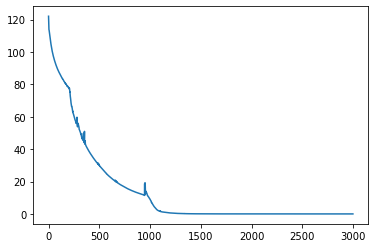

In [38]:
plt.plot(mses)

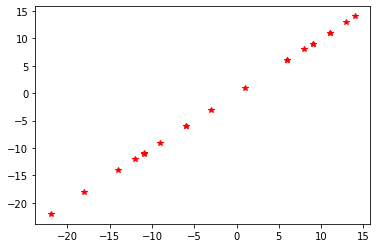

In [39]:
plt.plot(y_train.cpu().detach().numpy(),y_.cpu().detach().numpy(),'r*')

In [40]:
y = rnn(torch.tensor(data_train[0][None, 0,:],dtype=torch.float).to("cuda:0"))

In [41]:
y

tensor([[ -8.9977, -11.0027]], device='cuda:0', grad_fn=<AddmmBackward0>)